### Bibliotecas

In [231]:
import keras
from keras import layers, ops
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.datasets.mnist as mnist

### Parâmetros

In [232]:
original_dim = 784
epochs = 200
batch_size = 128
latent_dim = 2
hidden_dim = 64
num_classes = 10
beta = 0.01
input_shape = (28, 28, 1)

### Dataloader

In [233]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test  = x_test.astype("float32") / 255.

x_train = x_train.reshape((-1, original_dim))
x_test = x_test.reshape((-1, original_dim))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


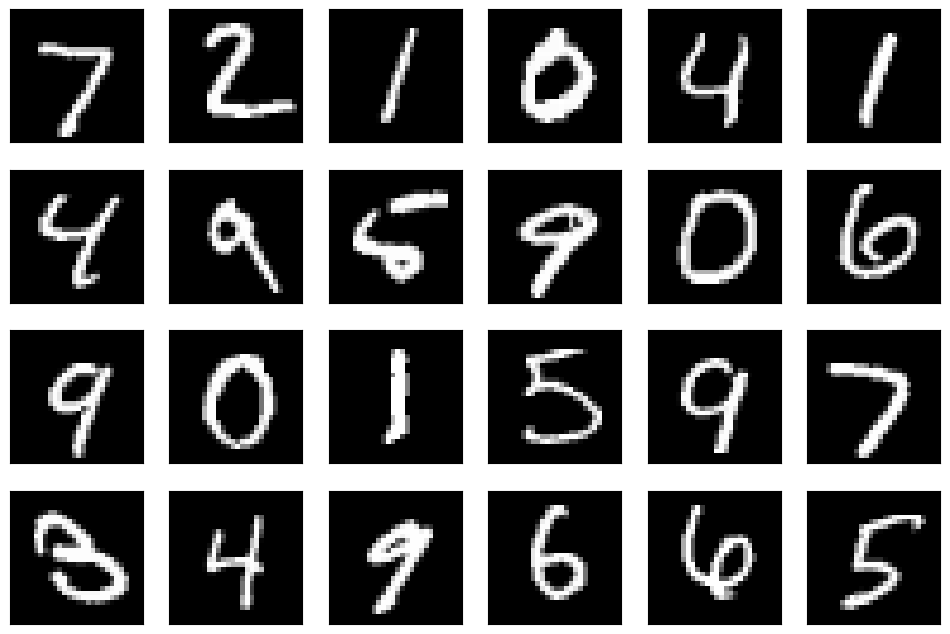

In [234]:
plt.figure(figsize=(12, 8))
for i in range(24):
    ax = plt.subplot(4, 6, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Arquitetura do Modelo

In [235]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps

#### Encoder

In [236]:
inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(hidden_dim, activation="relu")(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_var = layers.Dense(latent_dim)(h)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")

#### Decoder

In [237]:
latent_inputs = keras.Input(shape=(latent_dim,))
h = layers.Dense(hidden_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(h)

decoder = keras.Model(latent_inputs, outputs, name="decoder")

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def call(self, data):
        z_mean, z_log_var, z = self.encoder(data) 
        reconstruction = self.decoder(z)
        
        original_dim = ops.shape(data)[-1]
        reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)
        reconstruction_loss *= original_dim 
        reconstruction_loss = ops.mean(reconstruction_loss)
        
        kl_loss = -0.5 * ops.sum(1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var), axis=1)
        kl_loss = ops.mean(kl_loss)
        self.add_loss(reconstruction_loss + kl_loss)
        
        return reconstruction

In [252]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

history = vae.fit(
    x_train,
    epochs=200,
    batch_size=batch_size,
    validation_data=(x_test, None)
)

# vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Epoch 1/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 148.6947 - val_loss: 152.1123
Epoch 2/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 148.6592 - val_loss: 151.9868
Epoch 3/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 148.6825 - val_loss: 152.1611
Epoch 4/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 148.6885 - val_loss: 152.1142
Epoch 5/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 148.6188 - val_loss: 152.1074
Epoch 6/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148.6178 - val_loss: 152.0572
Epoch 7/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148.6313 - val_loss: 152.1758
Epoch 8/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148.6208 - val_loss: 151.8983
Epoch 9/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 148.5697 - val_loss: 152.1057
Epoch 10/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 148.5454 - val_loss: 152.2380
Epoch 11/200
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 148.5818 - val_loss: 151.96

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


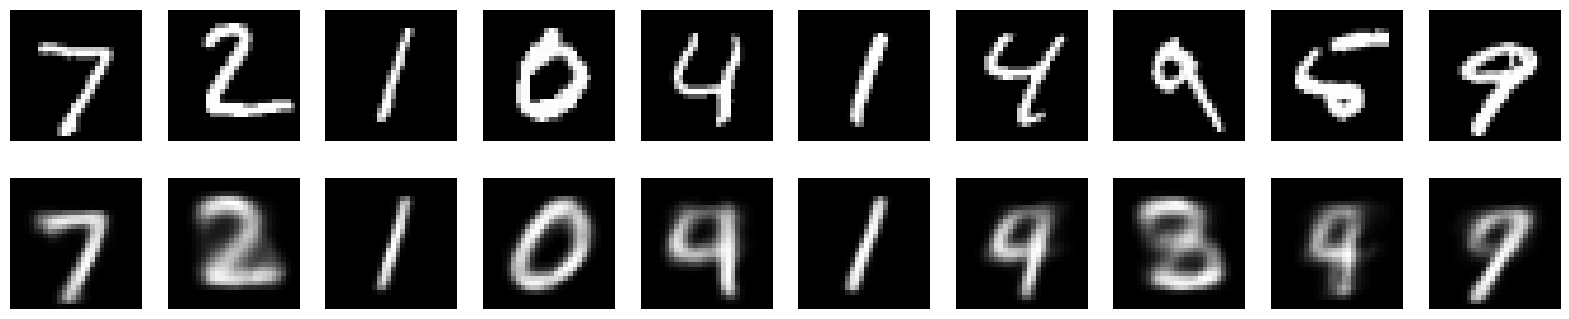

In [253]:
decoded = vae.predict(x_test[:10])

plt.figure(figsize=(20,4))
for i in range(10):
    # original
    ax = plt.subplot(2,10,i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.axis("off")

    # reconstrução
    ax = plt.subplot(2,10,i+11)
    plt.imshow(decoded[i].reshape(28,28))
    plt.gray()
    ax.axis("off")

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 550us/step


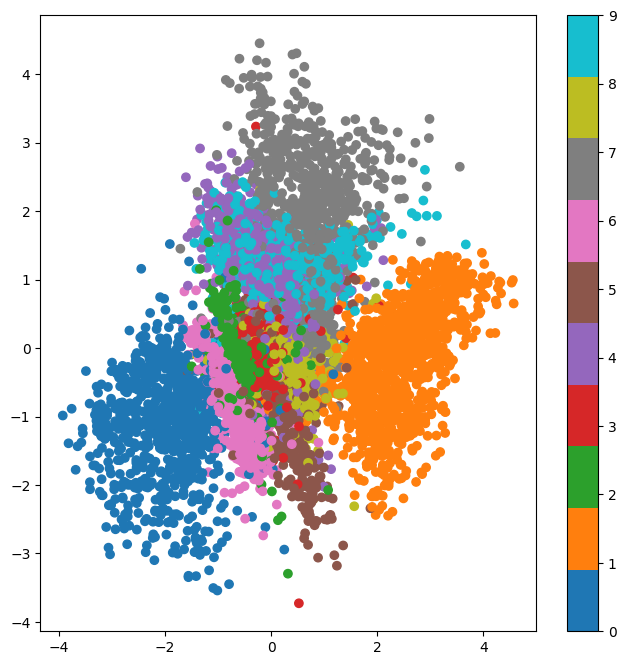

In [254]:
z_mean, z_log_var, z = encoder.predict(x_test)

plt.figure(figsize=(8,8))
plt.scatter(z[:,0], z[:,1], c=y_test, cmap="tab10")
plt.colorbar()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

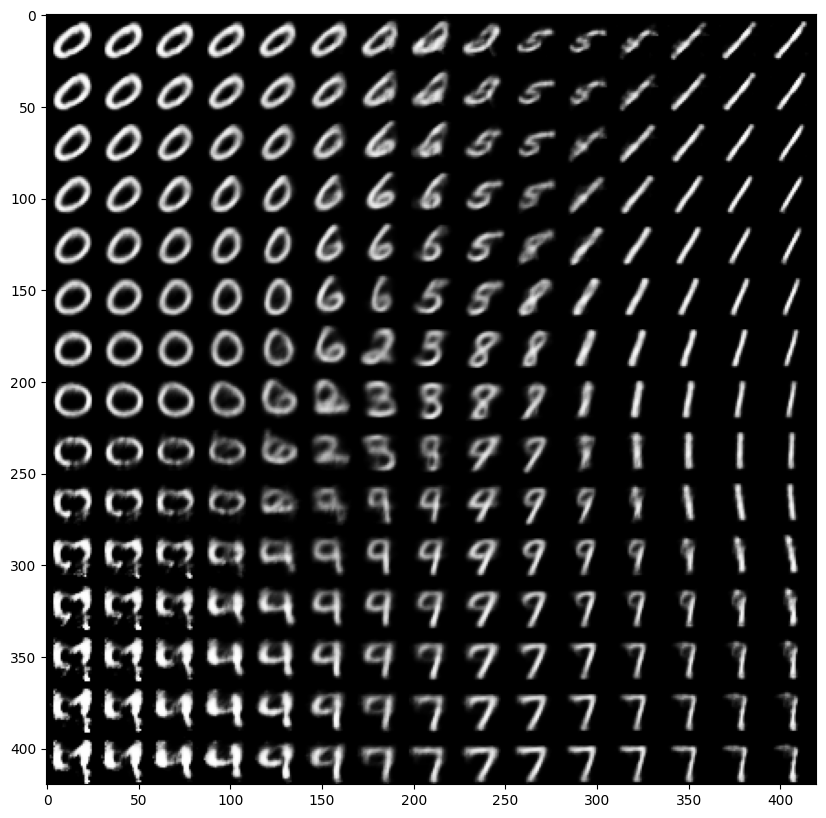

In [255]:
n = 15
figure = np.zeros((28 * n, 28 * n))

grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(28, 28)
        figure[i*28:(i+1)*28, j*28:(j+1)*28] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.gray()
plt.show()

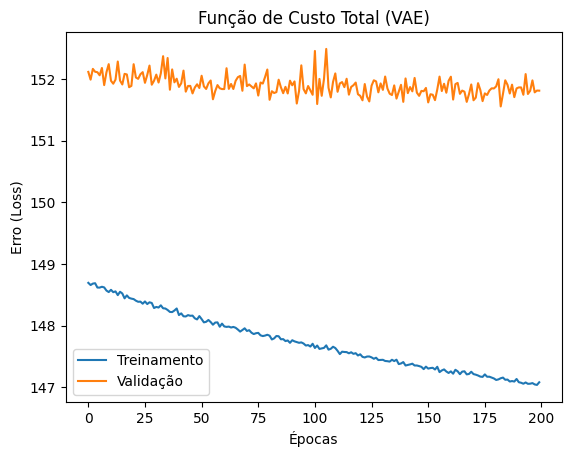

In [256]:
plt.figure()
plt.plot(history.history['loss'], label = 'Treinamento')
plt.plot(history.history['val_loss'], label = 'Validação')
plt.title('Função de Custo Total (VAE)')
plt.ylabel('Erro (Loss)')
plt.xlabel('Épocas')
plt.legend()
plt.show()

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step


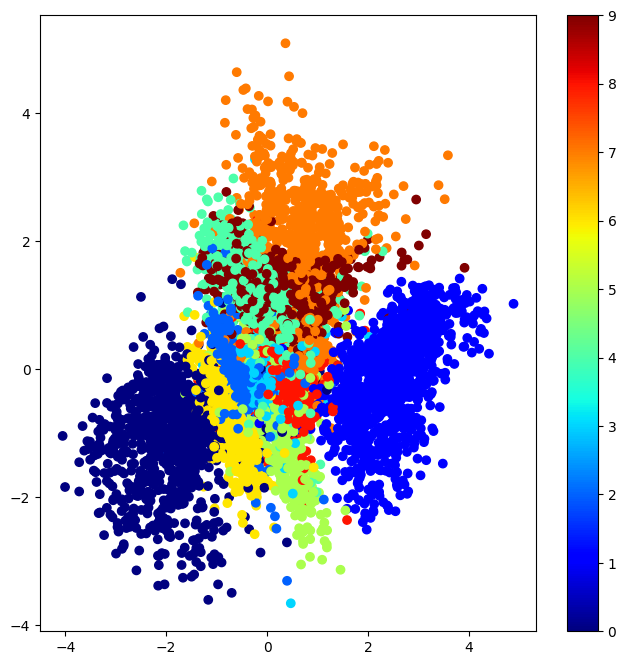

In [261]:
x_test_encoded = encoder.predict(x_test, batch_size=256)[2]

plt.figure(figsize=(8,8))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap=plt.cm.jet)
plt.colorbar()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


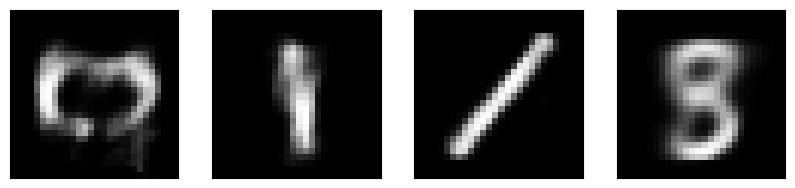

In [262]:
sampled = np.array([[-2,1], [2,1], [2,-2], [0,0]])
rec = decoder.predict(sampled)
plt.figure(figsize=(10, 4))
for i in range(4):
    ax = plt.subplot(1, 4, i + 1)
    plt.imshow(rec[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()